In [64]:
import pandas as pd
import torch
import numpy as np
from torch.utils.data import DataLoader

#%load_ext line_profiler

In [65]:
from model.eGauss_plus import eGAUSSp

In [66]:
# Load the dataset
file_path = 'Datasets/creditcard.csv'
data = pd.read_csv(file_path)


In [67]:
from utils.utils_dataset import balance_dataset
from utils.utils_dataset import prepare_dataset


device = torch.device("cpu")

num_clients = 4

data = balance_dataset(data)
X = data.iloc[:, :-1].values
y = data.iloc[:, -1].values
client_train, test_data, all_data = prepare_dataset(X, y, num_clients) 


In [68]:

# Model parameters
local_model_params = {
    "feature_dim": 30,
    "num_classes": 2,
    "N_max": 1,
    "num_sigma": 2,
    "kappa_join": 1.5,
    "S_0": 1e-10,
    "c_max": 2,
    "device": torch.device("cpu")
}
federated_model_params = {
    "feature_dim": 30,
    "num_classes": 2,
    "N_max": 1,
    "num_sigma": 2,
    "kappa_join": 1.5,
    "S_0": 1e-10,
    "c_max": 2,
    "device": torch.device("cpu")
}

# Initialize a model for each client
local_models = [eGAUSSp(**local_model_params) for _ in range(num_clients)]
federated_model = eGAUSSp(**federated_model_params)


Client 1: {0: 84, 1: 88}
Client 2: {0: 62, 1: 67}
Client 3: {0: 46, 1: 50}
Client 4: {0: 37, 1: 35}
Test Set: {0: 152, 1: 144}

Combined Number of Samples per Class:
Class 0: 381 samples
Class 1: 384 samples

Total Number of Samples Across All Datasets: 765


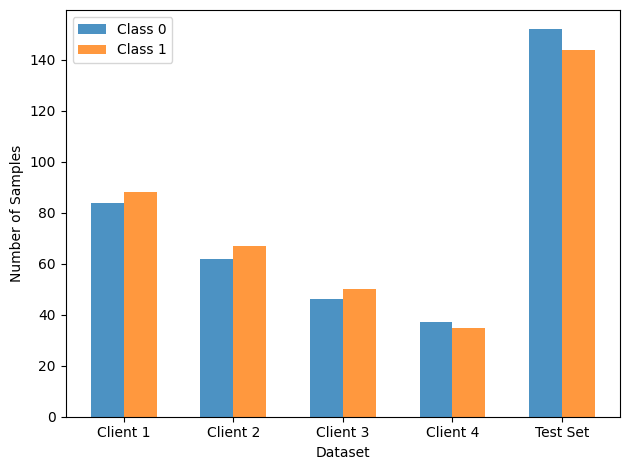

In [69]:
from utils.utils_dataset import prepare_non_iid_dataset, plot_dataset_split, display_dataset_split

display_dataset_split(client_train, test_data)
plot_dataset_split(client_train, test_data)

In [70]:
import utils.utils_train
from utils.utils_train import train_supervised, train_unsupervised
from utils.utils_plots import plot_first_feature

if False:

    # Assuming models and client_data are already defined
    for client_idx, client_model in enumerate(local_models):
        print(f"Training model for client {client_idx + 1}")
        train_supervised(client_model, client_train[client_idx]) 
        plot_first_feature(client_train[client_idx], model=client_model, num_sigma=2, N_max=1)  


In [71]:
import utils.utils_train
from utils.utils_train import train_models_in_threads
from utils.utils_plots import plot_first_feature

# Assuming local_models and client_train are already defined
# local_models is a list of models, client_train is a list of corresponding training datasets
train_models_in_threads(local_models, client_train)


Evolving has been enabled.
Evolving has been enabled.
Evolving has been enabled.
Evolving has been enabled.


Processed 72 points.Number of clusters: 72
Processed 96 points.Number of clusters: 93
Processed 129 points.Number of clusters: 126
Processed 172 points.Number of clusters: 105


In [74]:
from utils.utils_train import test_model   

# Testing each client's model on the global test dataset
for client_idx, client_model in enumerate(local_models):
    print(f"\nTesting model for client {client_idx + 1}")
    test_model(client_model, test_data)
    test_model(client_model, all_data)



Testing model for client 1


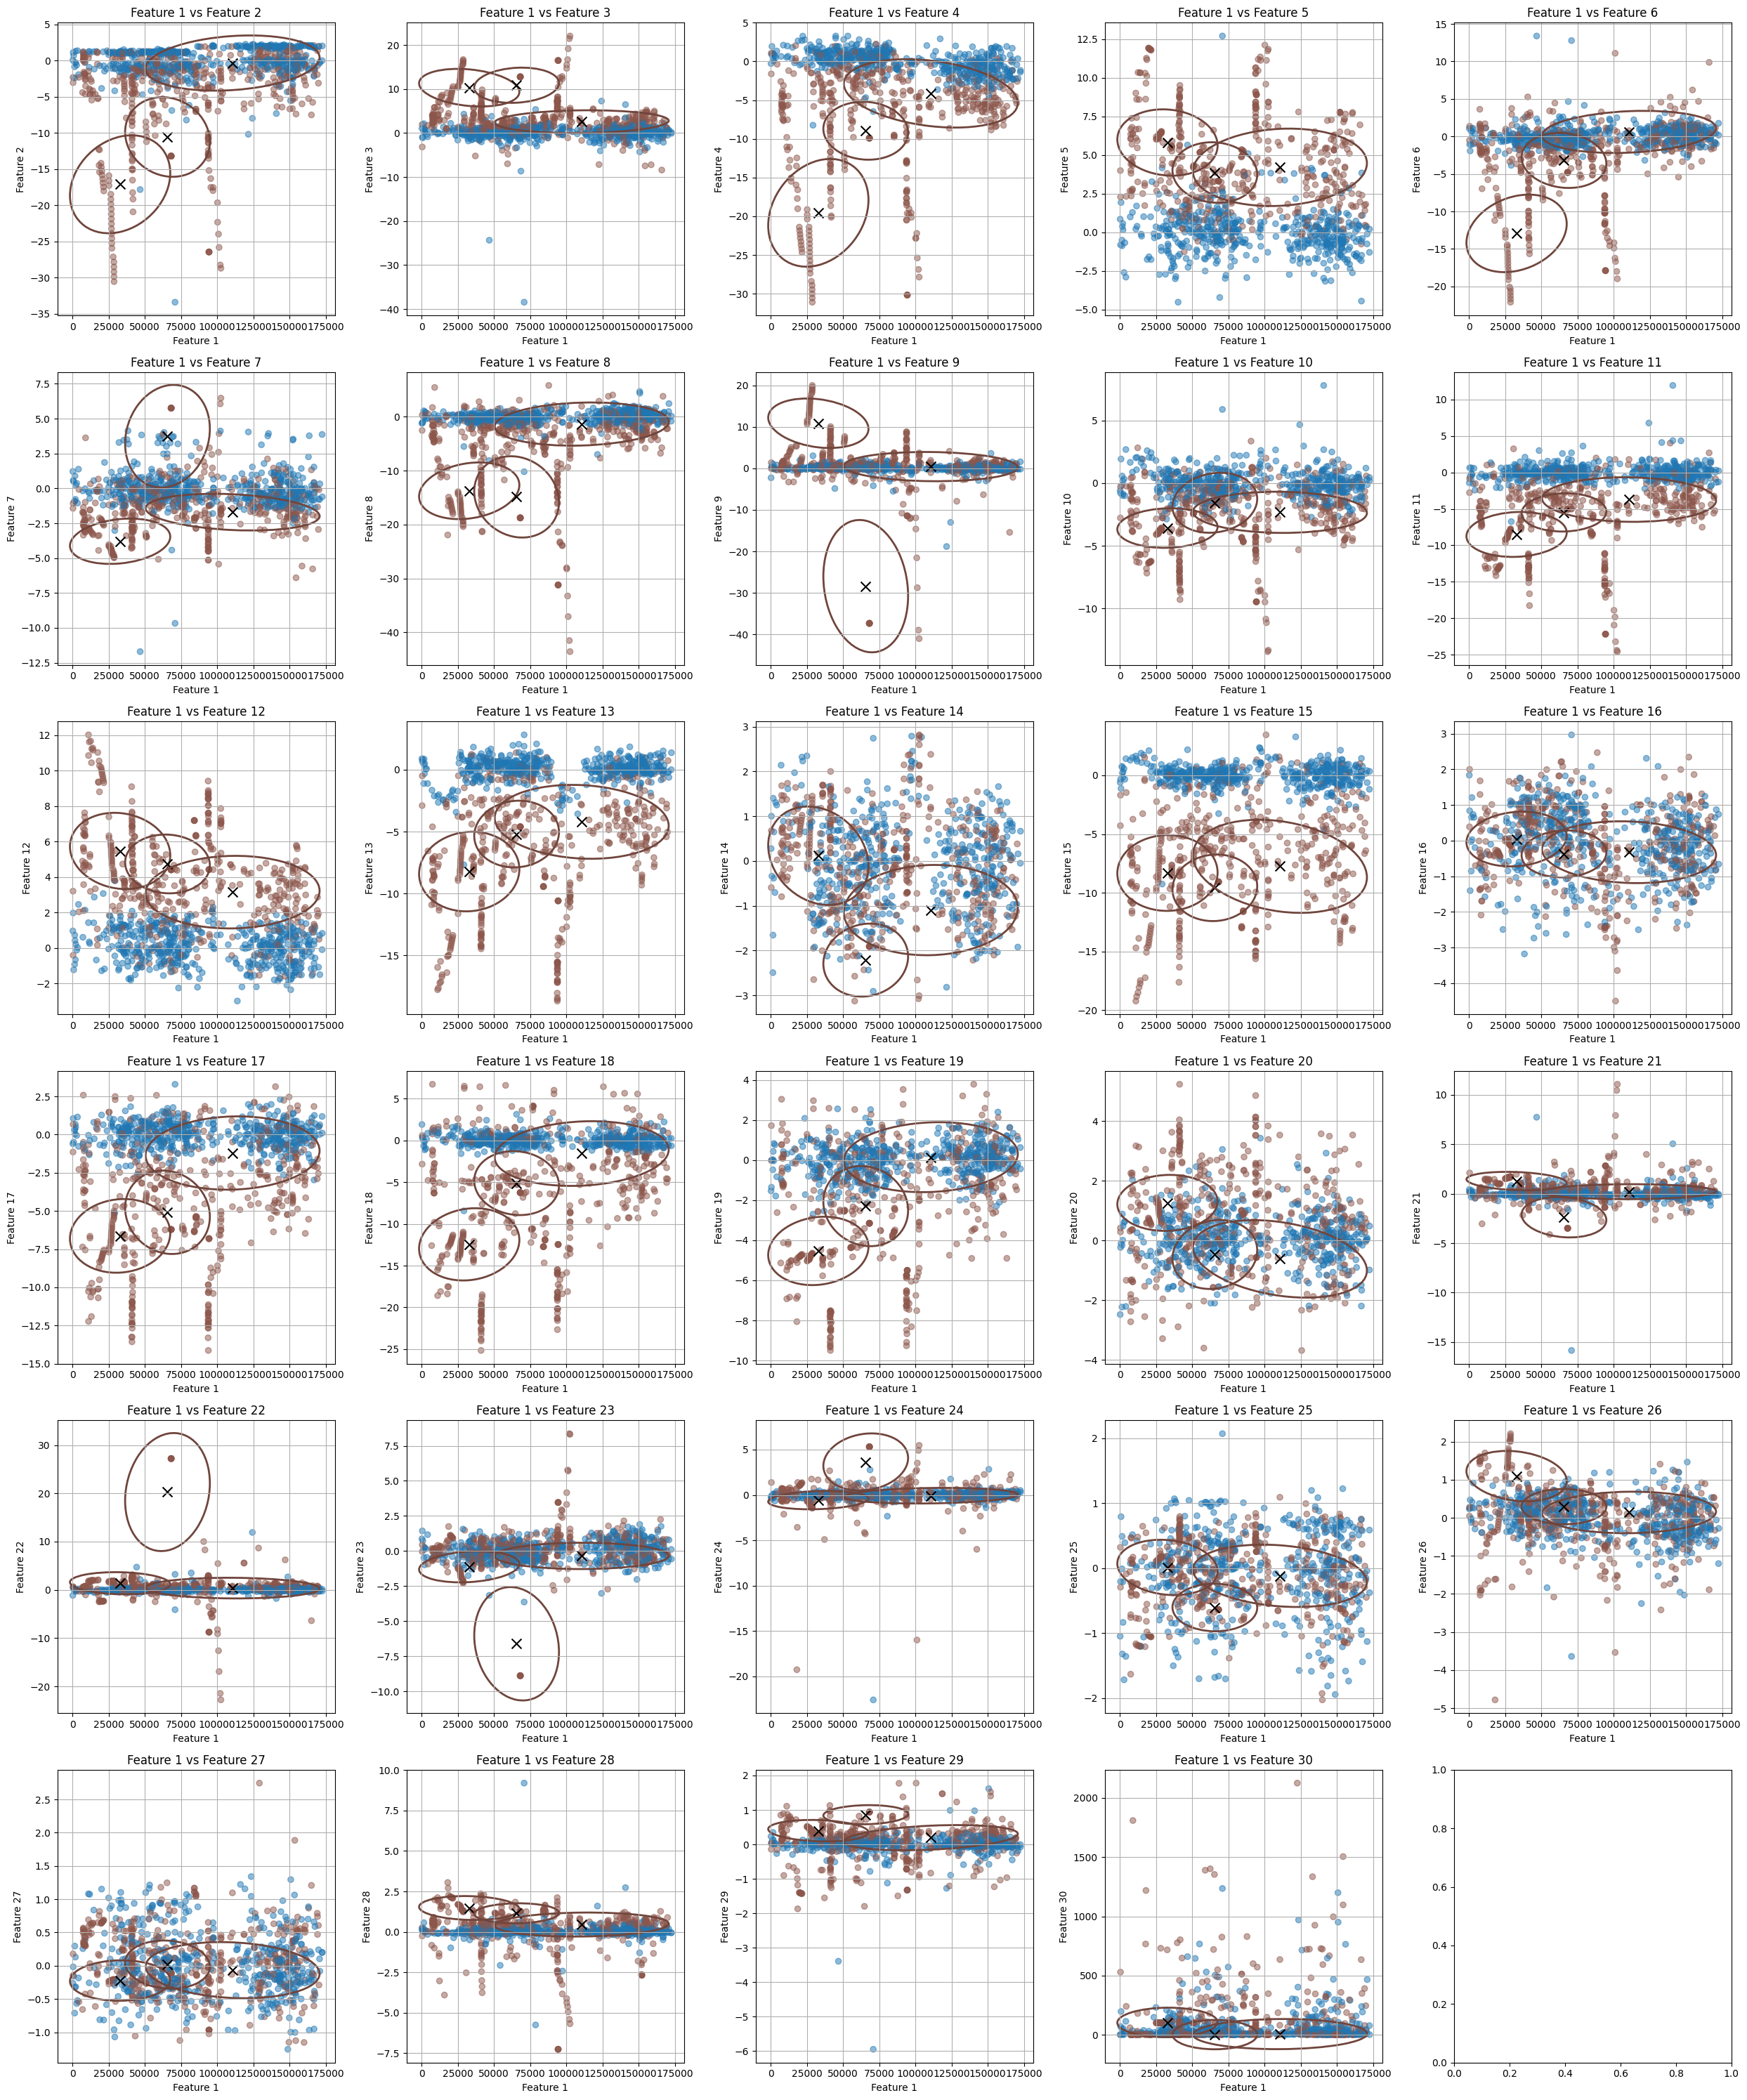


Testing federated model
Evolving has been disabled.
Test Accuracy: 0.5135135135135135, Precision: 0.75018261504748, Recall: 0.5135135135135135, F1 Score: 0.34845559845559837
Evolving has been disabled.
Test Accuracy: 0.5, Precision: 0.75, Recall: 0.5, F1 Score: 0.3333333333333333

Testing model for client 1
Evolving has been disabled.
Test Accuracy: 0.5135135135135135, Precision: 0.75018261504748, Recall: 0.5135135135135135, F1 Score: 0.34845559845559837
Evolving has been disabled.
Test Accuracy: 0.5, Precision: 0.75, Recall: 0.5, F1 Score: 0.3333333333333333

Testing model for client 2
Evolving has been disabled.
Test Accuracy: 0.8783783783783784, Precision: 0.8788692379776585, Recall: 0.8783783783783784, F1 Score: 0.8782615147748984
Evolving has been disabled.
Test Accuracy: 0.8902439024390244, Precision: 0.8928405083505223, Recall: 0.8902439024390244, F1 Score: 0.8900622351694916

Testing model for client 3
Evolving has been disabled.
Test Accuracy: 0.902027027027027, Precision: 0.

In [73]:
from utils.utils_train import test_model

for client_idx, client_model in enumerate(local_models):
        print(f"Merging client {client_idx + 1}")
        federated_model.federal_agent.merge_model(client_model)

federated_model.federal_agent.federated_merging()

plot_first_feature(all_data, model=federated_model, num_sigma=2, N_max=2)   

print(f"\nTesting federated model")   

test_model(federated_model, test_data)
test_model(federated_model, all_data)
        
# Testing each client's model on the global test dataset
for client_idx, client_model in enumerate(local_models):
    print(f"\nTesting model for client {client_idx + 1}")
    test_model(client_model, test_data)
    test_model(client_model, all_data)
